In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## VECTOR AUTO REGRESSION EQUATION:
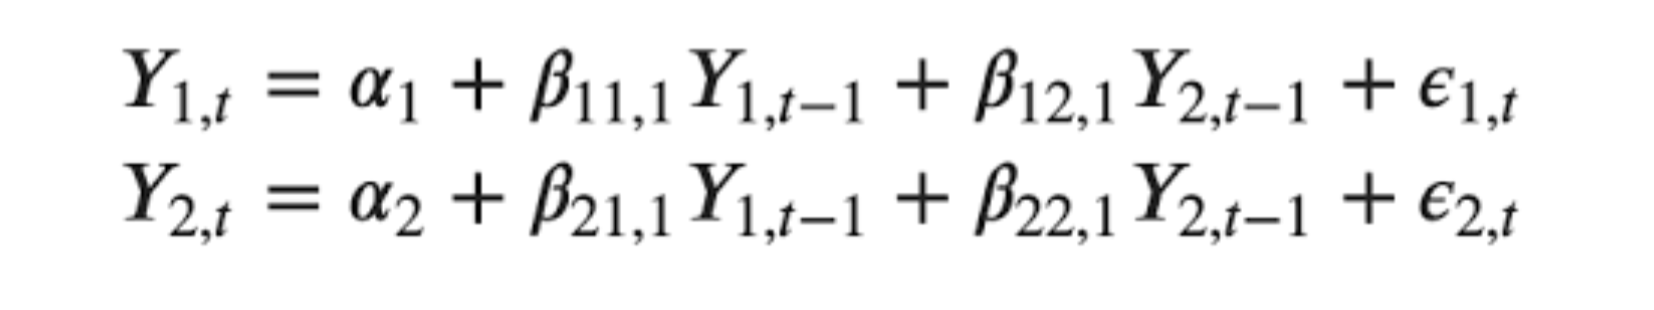
####  We use the Vector Auto Regression equation. Where there are two or more time series that are interdependent. Usually, in auto regression, what we do is we want to make a prediction in the future, and we use the previous time lags of a particular time series to make prediction in to the future. In VAR, we assume that there are two-time series that have a correlation, so when we are predicting a time series, Let's say y1, which y1,t-1 as well as the previous time lag of some other time series y2. Similarly, we can look at the equation of y2 as well, which is dependent on both the previous lag of y2 as well as the previous lag of y1.

In [2]:
#load dataset
df = 'https://raw.githubusercontent.com/abhijnr1/dataset/main/dataset.csv'  
df = pd.read_csv(df, parse_dates=['year'], index_col=['year'])  # read a dataset using read_csv ,
     # we provide the url of data and  mention the parse_dates = year column so that
     # pandas understands the year column has year values and it does not  treated like a string.
    # after we mentioned the index_col as year.
print(df.shape)  #printing the shape of dataset
df.drop(['quarter'], axis = 1,inplace = True)
df.head()  #used to get the first 5 rows

(203, 13)


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
year,,,,,,,,,,,,
1971-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1971-01-01,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1971-01-01,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1971-01-01,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1972-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Plot the Data Set to get a feel of what the data actually look like and for that i'm gonna be using matplotlib liberary 

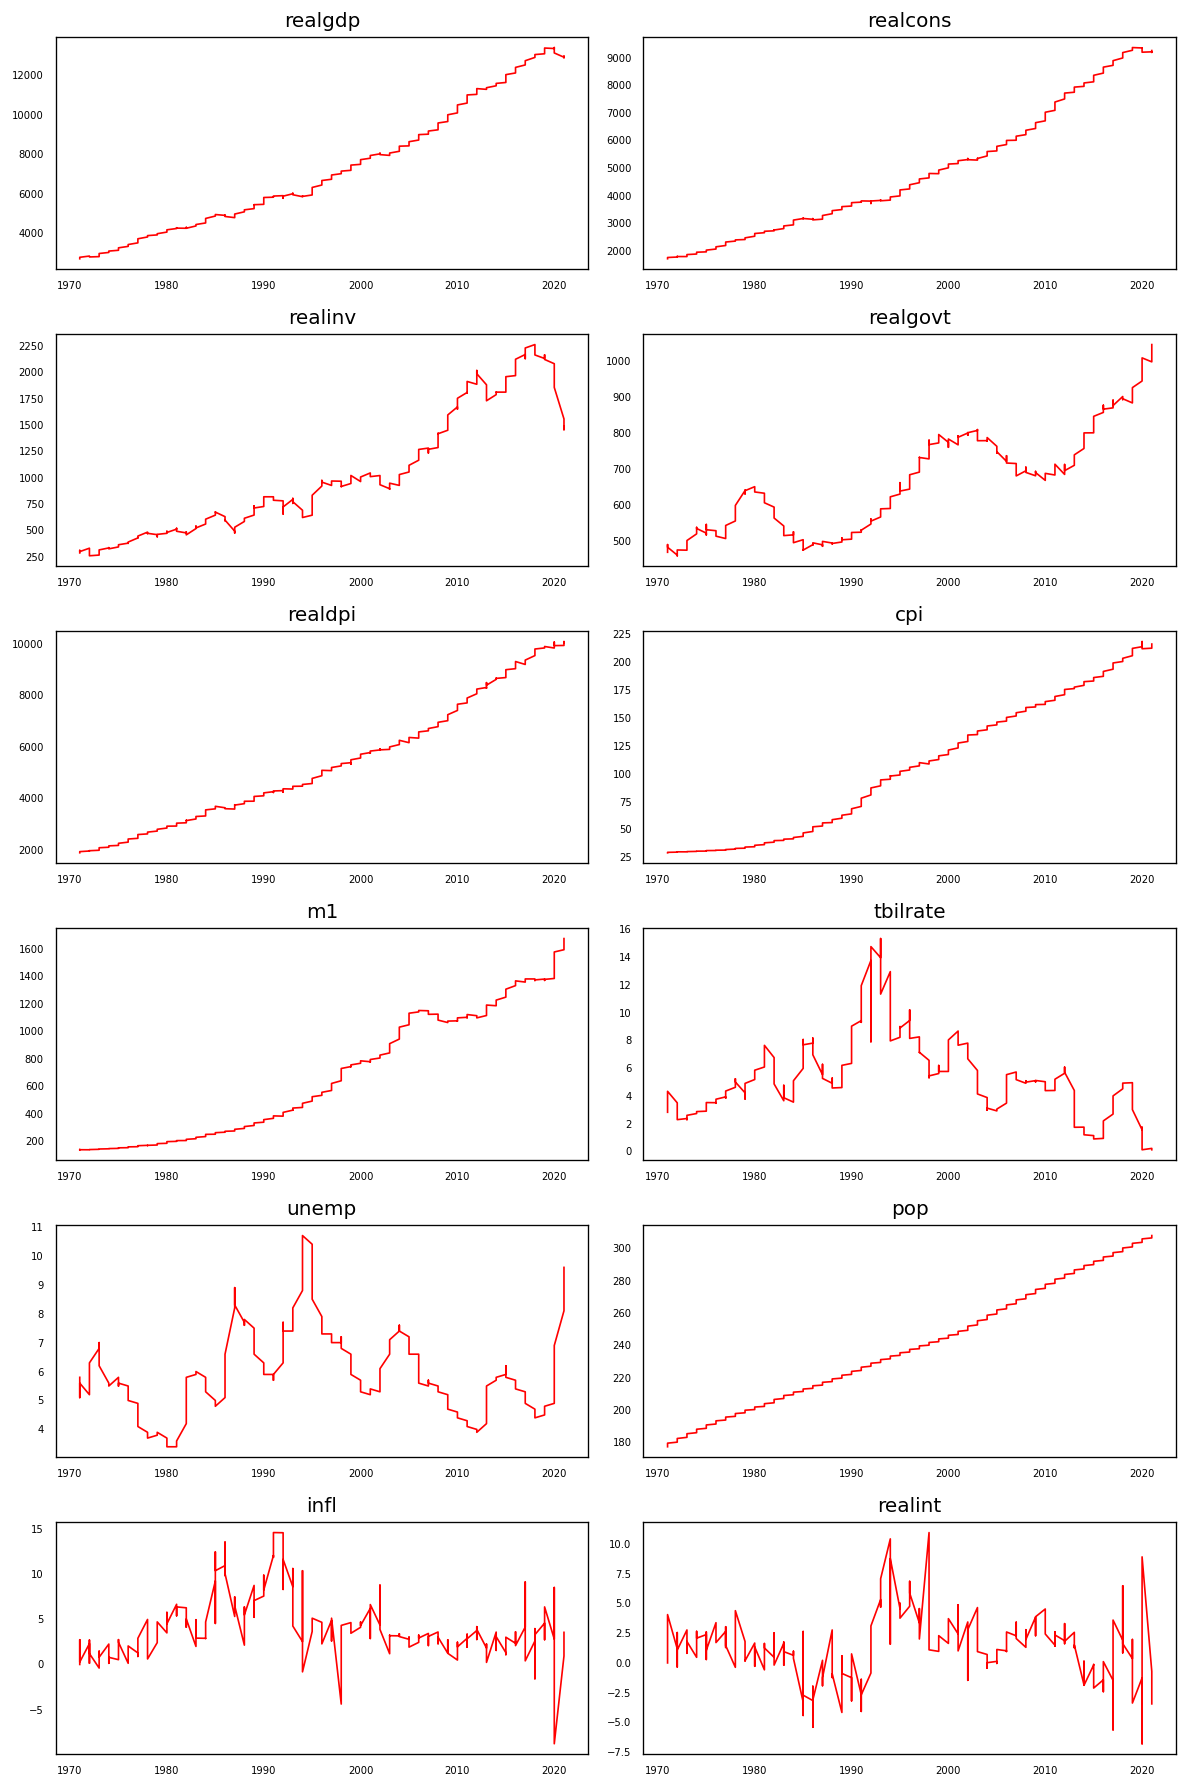

In [3]:
fig, axes = plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10,15))  # creating subplots
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]                 #all columns are gonna be plotted with their respective names.
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])          # set title with their respective column names
    ax.xaxis.set_ticks_position('none')   #Set the ticks position.
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(6)  # spines are the lines confining the plot area 
    ax.tick_params(labelsize=6) 

plt.tight_layout();

# Firstly , we work with two time series that is  Real GDP and Realinv

### Now we check if your data is stationary or not , So we use the augmented Dickey–Fuller test (ADF) test.

In [4]:
ad_fuller_result_1 = adfuller(df['realgdp']) # here we provied for which time series we are going to test. i.e. real gdp 

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')  # printing ADF statistic value
print(f'p-value: {ad_fuller_result_1[1]}')     # printing p-value

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['realinv']) # here we are going to test for realinv
print('realinv')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')       #printing ADF statistic value
print(f'p-value: {ad_fuller_result_2[1]}')             # printing p-value

realgdp
ADF Statistic: 1.7504627967647273
p-value: 0.9982455372335032

---------------------

realinv
ADF Statistic: -1.2572522246532587
p-value: 0.6484956579101149


#### now , we got  p- values , if p-value <= 0.05 that means your data is stationary otherwise its not. so, we can se here the p-value is 0.998 and 0.997 which means that data is not stationary

#### So now , to make it Stationary we use Differencing by using diff()[1:]  

In [5]:
ad_fuller_result_1 = adfuller(df['realgdp'].diff()[1:])  # to make it Stationary we use diff()[1:]  

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}') 
print(f'p-value: {ad_fuller_result_1[1]}')     # printing p-value

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['realinv'].diff()[1:])   # to make it Stationary we use diff()[1:]  
print('realinv')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')       
print(f'p-value: {ad_fuller_result_2[1]}')             # printing p-value

realgdp
ADF Statistic: -6.305695561658109
p-value: 3.3278821876681505e-08

---------------------

realinv
ADF Statistic: -5.350594702118342
p-value: 4.297932808177112e-06


#### Now, our both p-values are less than 0.05. which means that dataset is now stationary

### so, When we doing Vector Order Regression it is important to check that the two time series that we'r working with , Are they  correlated or not . so we use Granger Causality test function which we have stat model liberary. 

In [6]:
print('realgdp causes realinv ?\n')
print('------------------')
granger_1 =  grangercausalitytests(df[['realinv', 'realgdp']], 4)   # does realgdp cause realinv 
                                        # 4 is specify for how many lags do i want to check for.
print('------------------')
print('------------------')
print('\realinv causes realgdp ?\n')     # does realinv cause realgdp
print('------------------')
granger_2 = grangercausalitytests(df[['realgdp', 'realinv']], 4)

realgdp causes realinv ?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7431  , p=0.3897  , df_denom=199, df_num=1
ssr based chi2 test:   chi2=0.7543  , p=0.3851  , df=1
likelihood ratio test: chi2=0.7529  , p=0.3856  , df=1
parameter F test:         F=0.7431  , p=0.3897  , df_denom=199, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.5985 , p=0.0000  , df_denom=196, df_num=2
ssr based chi2 test:   chi2=36.0949 , p=0.0000  , df=2
likelihood ratio test: chi2=33.1963 , p=0.0000  , df=2
parameter F test:         F=17.5985 , p=0.0000  , df_denom=196, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.3638 , p=0.0000  , df_denom=193, df_num=3
ssr based chi2 test:   chi2=47.7631 , p=0.0000  , df=3
likelihood ratio test: chi2=42.8312 , p=0.0000  , df=3
parameter F test:         F=15.3638 , p=0.0000  , df_denom=193, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

#### The p-value should be less than 0.05 , if it is , that means that above hypothesis is true. now bye seeing above p -values . i have to take a lag greater than one if i want to forcasting for this.

### Now , before actually fitting a model into the time series and fitting it we have to split the dataset into training and testing.  

In [7]:
df = df[['realgdp','realinv']]  # extract two columns that i'm gonna working with.
print(df.shape)                #Print the shape

(203, 2)


In [8]:
train_df=df[:-18]   
test_df=df[-18:]    # now  i am taking last 18 values for test part and the rest values in the training part.

In [9]:
print(test_df.shape)  # shape test data

(18, 2)


### How many numbers of lags do we want to consider. for that we are going to using the VAR class 

In [10]:
model = VAR(train_df.diff()[1:])    # provide the difference data

### we are not fit the model here because we are not use this class to fit the model. we use this because it provides the function called a select_order where we simply provide the maximum lags that we want to consider. 

In [11]:
sorted_order=model.select_order(maxlags=20)   # here we give maximum lags = 20
print(sorted_order.summary()) # now it prints the summary and it automatically run the analysis and it give us scores like AIC , BIC , FPE , HQIC

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.40       14.44   1.795e+06       14.42
1        14.27      14.39*   1.583e+06       14.32
2        14.24       14.43   1.527e+06      14.32*
3        14.21       14.48   1.488e+06       14.32
4        14.24       14.58   1.531e+06       14.38
5        14.21       14.63   1.489e+06       14.38
6        14.22       14.72   1.506e+06       14.42
7        14.26       14.83   1.560e+06       14.49
8        14.21       14.86   1.492e+06       14.48
9       14.21*       14.93  1.486e+06*       14.50
10       14.26       15.05   1.559e+06       14.58
11       14.30       15.17   1.627e+06       14.65
12       14.33       15.27   1.675e+06       14.71
13       14.34       15.36   1.697e+06       14.75
14       14.37       15.47   1.755e+06       14.82
15       14.40       15.58   1.819e+06       14.88
16       14.40       15.64   1.

#### Now, it highlights with * , where the minimum was found . now in this case the minimum was found in lag number 9. now we'r going to use past 9 lags to build our model.

### To fit the model , we use the VARMAX class. we have to simply provide the training data . here i am providing stationary data because in VARMAX  class if we set enforce_stationarity = True ,  it will a automatically tarnsform the AR parameters to ensure there is stationary

In [12]:
var_model = VARMAX(train_df, order=(9,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)  # fit the model using var_model.fit
print(fitted_model.summary())     # print the summary

                             Statespace Model Results                             
Dep. Variable:     ['realgdp', 'realinv']   No. Observations:                  185
Model:                             VAR(9)   Log Likelihood               -1800.172
                              + intercept   AIC                           3682.344
Date:                    Sun, 12 Jun 2022   BIC                           3814.378
Time:                            17:49:28   HQIC                          3735.854
Sample:                                 0                                         
                                    - 185                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.04, 0.50   Jarque-Bera (JB):         13.54, 18.64
Prob(Q):                        0.85, 0.48   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.83, 3.15   Skew:                      0.33, -0.52
P

In [13]:
n_forecast =  18  # it going to make 6 quarter in the future.
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1) #here we provide from where we want to start making predication and the end date  
 # start date is length of training dataset, so wherever the tarining dataset ends from there i want to start making predication.
predictions=predict.predicted_mean   # gives the mean of all predications  
print(predict)

In [14]:
predictions.columns=['realgdp_predicted','realinv_predicted']
predictions

,realgdp_predicted,realinv_predicted
185,12604.583408,2185.891410
186,12662.984778,2186.874492
187,12724.171424,2197.227797
188,12786.732197,2212.866248
189,12834.234858,2209.315493
190,12882.909859,2213.414029
191,12921.489244,2212.354437
192,12954.917569,2202.909921
193,12992.353516,2203.873021
194,13029.499277,2207.162057


In [15]:
test_vs_pred=pd.concat([test_df,predictions])  # concating the original testing dataset and the predications

<AxesSubplot:>

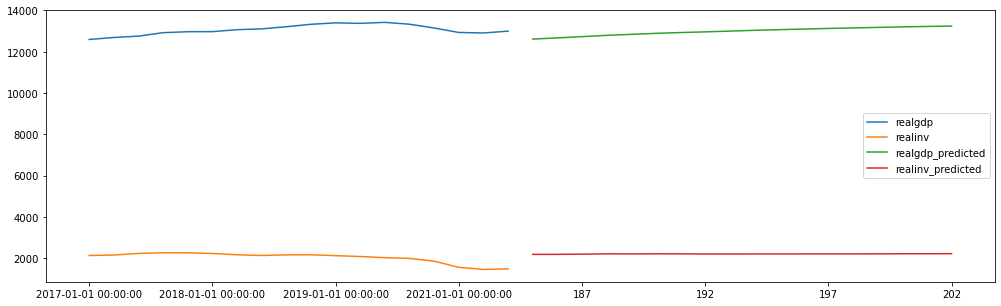

In [16]:
test_vs_pred.plot(figsize=(17,5))  #plot this with figure size 17,5

### Now , We put the score to how good it is doing . we can find out the mean square error . 


In [17]:
# from sklearn.metrics import mean_squared_error
import math 
from statistics import mean
from sklearn.metrics import mean_squared_error

rmse_realgdp=math.sqrt(mean_squared_error(predictions['realgdp_predicted'],test_df['realgdp'])) # providng test value and prediction values
print('Mean value of real gdp is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['realgdp']),rmse_realgdp))

rmse_realinv=math.sqrt(mean_squared_error(predictions['realinv_predicted'],test_df['realinv']))
print('Mean value of realinv is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['realinv']),rmse_realinv))

Mean value of real gdp is : 13055.918. Root Mean Squared Error is :203.9733160573011
Mean value of realinv is : 2026.9026666666666. Root Mean Squared Error is :316.2994108867531


### here, i am  printing two things  root mean square error as well as the mean value. and general logic is ,  if our mean value = 100 , then the root mean square error is way less then that. and here our mean value for real GDP is 13055.918 and Root mean squared error is 203.973 , which pretty good because it less than 10% of the mean value.